In [2]:
!nvidia-smi

Thu Oct  1 09:43:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import albumentations
from albumentations import pytorch

import multiprocessing as mp
from timeit import default_timer as timer

%matplotlib inline

In [5]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/nomeroff+chelhack.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')
    

In [6]:
train_dir = '/content/dataset/nomeroff+chelhack/train'
val_dir = '/content/dataset/nomeroff+chelhack/val'
test_dir = '/content/dataset/nomeroff+chelhack/test'
train_files = os.listdir(train_dir)
val_files = os.listdir(val_dir)
test_files = os.listdir(test_dir)

print(len(train_files), len(val_files), len(test_files))

7451 965 500


In [7]:
import json

with open('/content/dataset/nomeroff+chelhack/train_labels.json', 'r') as json_file:
    train_labels = json.load(json_file)

with open('/content/dataset/nomeroff+chelhack/val_labels.json', 'r') as json_file:
    val_labels = json.load(json_file)

In [8]:
train_labels['10791007-viber-image23.jpg']

[{'all_points_x': [1180, 1180, 1054, 1047],
  'all_points_y': [474, 528, 621, 568]}]

(720, 1280, 3)


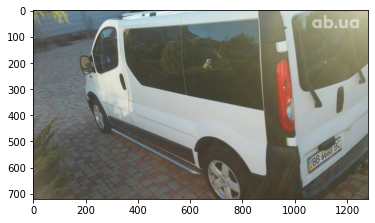

In [9]:
img = cv2.imread('/content/dataset/nomeroff+chelhack/train/10791007-viber-image23.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

(720, 1280)


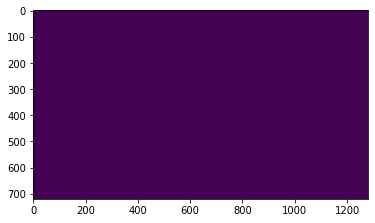

In [10]:
import numpy as np


height, width = img.shape[:2]
background = np.zeros((height, width))
x_coordinates = [1180, 1180, 1054, 1047]
y_coordinates = [474, 528, 621, 568]
print(background.shape)
plt.imshow(background)

In [11]:
from PIL import Image, ImageDraw

def create_mask(background, x_coordinates, y_coordinates):
      height, width = background.shape
      polygon = [(x, y) for x, y in zip(x_coordinates, y_coordinates)]
      img = Image.fromarray(background)
      ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
      mask = np.array(img)
      return mask

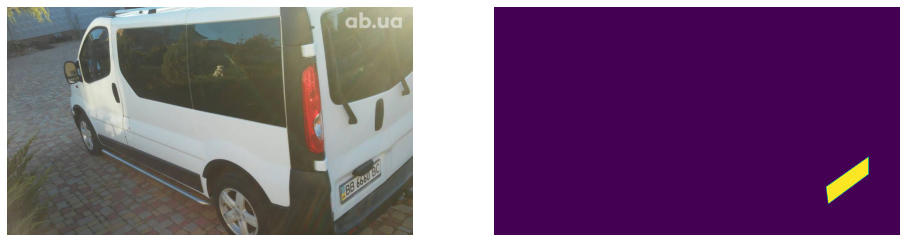

In [12]:
mask = create_mask(background, x_coordinates, y_coordinates)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
for i, picture in enumerate((img, mask)):
    ax[i].set_axis_off()
    ax[i].imshow(picture)

In [13]:
class ANP(Dataset):
    def __init__(self, dir_path, file_list, bboxs=None, transform=None):
        self.dir_path = dir_path
        self.file_list = file_list
        self.bboxs = bboxs
        # self.coco = COCO(bboxs)
        # self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):        
        image_name = os.path.join(self.dir_path, self.file_list[idx])

        image = cv2.imread(image_name, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        height, width, _ = image.shape
        boxes = torch.FloatTensor([])
        masks = np.zeros((height, width))
        n_objs = 0
        for name, bbs in self.bboxs.items():
            if name == image_name.split('/')[::-1][0]:
                n_objs = len(bbs)
                for bb in bbs:
                    x1 = min(bb['all_points_x'])
                    x2 = max(bb['all_points_x'])
                    y1 = min(bb['all_points_y'])
                    y2 = max(bb['all_points_y'])
                    all_bb = torch.FloatTensor([[x1, y1, x2, y2]])
                    boxes = torch.cat((boxes, all_bb))
                    masks = create_mask(masks, bb['all_points_x'], bb['all_points_y'])

        labels = torch.ones((n_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objs,), dtype=torch.int64)

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target["masks"] = masks
        target['image_id'] = image_id
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'masks': target['masks'],
                'labels': labels
            }
            sample = self.transform(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

In [14]:
batch_size = 4
num_workers = mp.cpu_count()
num_classes = 2

In [15]:
def transform():
    return albumentations.Compose([
            # albumentations.Resize(img_size, img_size),
            # albumentations.Flip(0.5),
            pytorch.ToTensor()
            ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    
def collate_fn(batch):
    return tuple(zip(*batch))

In [16]:
train_set = ANP(train_dir, train_files, train_labels, transform())
valid_set = ANP(val_dir, val_files, val_labels, transform())
# test_set =  ANP(test_dir, test_files, transform())

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
# testloader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

In [17]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model

In [20]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


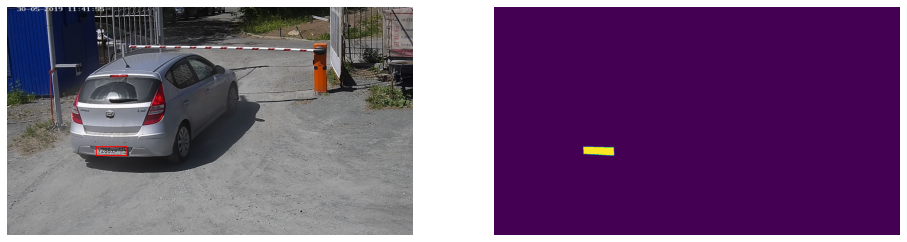

In [21]:
images, targets = next(iter(trainloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()
mask = targets[2]['masks'].cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
for i, picture in enumerate((sample, mask)):
    ax[i].set_axis_off()
    ax[i].imshow(picture)
plt.show()

In [22]:
model = get_model(num_classes)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [23]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [24]:
mask_model = get_model_instance_segmentation(num_classes)
params = [p for p in mask_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [25]:
def train(model, num_epochs, optimizer, lr_scheduler):
    model.to(device)
    loss_hist = Averager()
    itr = 1

    for epoch in range(num_epochs):
        loss_hist.reset()
        
        for images, targets in trainloader:
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 200 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1
        
        # update the learning rate
        lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}") 
    return model  

In [26]:
trained_model = train(model, 1, optimizer, lr_scheduler)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Iteration #200 loss: 1.081319808959961
Iteration #400 loss: 0.9420114755630493
Iteration #600 loss: 1.0668950080871582
Iteration #800 loss: 0.9193378686904907
Iteration #1000 loss: 1.0506539344787598
Iteration #1200 loss: 1.198016881942749
Iteration #1400 loss: 0.8745492100715637
Iteration #1600 loss: 0.9931839108467102
Iteration #1800 loss: 0.9813686609268188
Epoch #0 loss: 1.0907407734449104


In [27]:
def predict(model, image_path):
    model.eval()
    cpu_device = torch.device("cpu")

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    image_tensor = pytorch.ToTensor()(image=image)
    image_tensor = image_tensor['image']
  
    outputs = model(image_tensor.unsqueeze(0))
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    print(outputs)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in outputs[0]['boxes']:
        cv2.rectangle(image, (box[0], box[1]),
                      (box[2], box[3]), (220, 0, 0), 2)
    image_name = image_path.split('/')[::-1][0]
    cv2.imwrite(f'/content/predict/{image_name}', image)
    ax.set_axis_off()
    ax.imshow(image)

In [28]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [29]:
model = get_model(num_classes)
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[2.5157e+02, 1.2710e+02, 5.1237e+02, 2.4675e+02],
        [2.5793e+02, 0.0000e+00, 4.8682e+02, 1.8888e+02],
        [2.6184e+02, 1.6261e+02, 6.0843e+02, 2.9651e+02],
        [2.9951e+02, 0.0000e+00, 5.5217e+02, 2.8388e+02],
        [2.3711e+02, 4.5628e+00, 5.0305e+02, 3.8851e+02],
        [8.8376e+01, 1.9419e+01, 5.0172e+02, 8.5508e+01],
        [7.6430e+01, 0.0000e+00, 5.9139e+02, 3.4806e+02],
        [2.7685e+02, 1.6469e+02, 4.4572e+02, 2.2591e+02],
        [2.4448e+02, 1.8527e+02, 4.3237e+02, 2.3960e+02],
        [1.9990e+02, 4.9008e+01, 4.5521e+02, 2.7001e+02],
        [2.3581e+02, 1.1846e+02, 4.4083e+02, 3.0845e+02],
        [1.6337e+02, 1.4230e+02, 4.5132e+02, 3.9109e+02],
        [1.7008e+02, 0.0000e+00, 6.3474e+02, 7.6280e+01],
        [4.4225e+02, 0.0000e+00, 6.3805e+02, 4.3761e+02],
        [1.2413e+02, 9.8978e+00, 3.8213e+02, 2.8615e+02],
        [8.5985e+01, 1.7953e+01, 3.9623e+02, 4.5970e+02],
        [1.3235e+02, 9.8727e+01, 5.6790e+02, 2.8256e+02],
   

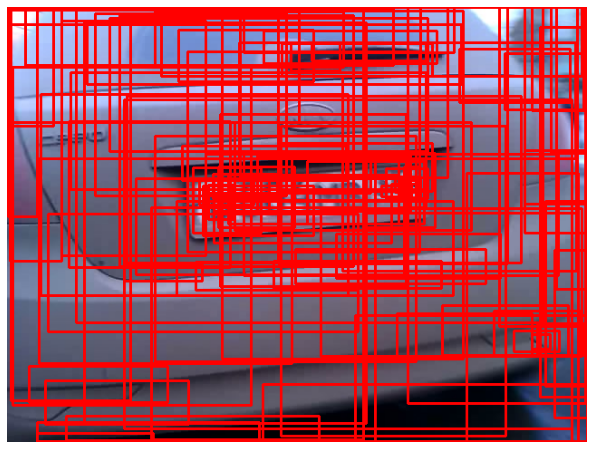

In [30]:
file_path = '/content/dataset/nomeroff+chelhack/test/21_5_2014_18_43_54_244.jpg'
predict(model, file_path)

In [ ]:
def train_mask_rcnn():
  pass

In [ ]:
trained_mask_model = train_mask_rcnn(mask_model, 1, optimizer, lr_scheduler)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


IndexError: ignored